# Baseline Models - Train, Compare & Predict

Trains all 9 baseline models (17 configs), compares RMSE/accuracy,
tunes hyperparameters, builds an ensemble, and generates Round 1 predictions.

**Run all cells top-to-bottom with Shift+Enter.**

## 1. Setup

In [1]:
import sys, os, pathlib

# Reliably set cwd to the python/ folder
_cwd = pathlib.Path(os.path.abspath('')).resolve()
if (_cwd / 'python').is_dir():
    _python_dir = _cwd / 'python'                          # workspace root
elif _cwd.name == 'baseline' and (_cwd.parent.parent / 'data').is_dir():
    _python_dir = _cwd.parent.parent                       # training/baseline/
elif _cwd.name == 'training' and (_cwd.parent / 'data').is_dir():
    _python_dir = _cwd.parent                              # training/
elif (_cwd / 'data').is_dir():
    _python_dir = _cwd                                     # already in python/
else:
    raise RuntimeError(f'Cannot locate python/ directory from {_cwd}')

os.chdir(_python_dir)
sys.path.insert(0, str(_python_dir))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils.baseline_model import (
    GlobalMeanBaseline, TeamMeanBaseline, HomeAwayBaseline,
    MovingAverageBaseline, WeightedHistoryBaseline, PoissonBaseline,
    DixonColesBaseline, BayesianTeamBaseline, EnsembleBaseline,
    compare_baselines
)

print(f'CWD: {os.getcwd()}')
print('Imports OK')

CWD: C:\Users\iscur\code\smiles\CSVy_wharton\python
Imports OK


c:\Users\iscur\code\smiles\CSVy_wharton\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Load WHL Data

In [2]:
df = pd.read_csv('data/whl_2025.csv')

# Aggregate shifts to game-level (sum per-shift goals to get game totals)
games = df.groupby('game_id').agg(
    home_team=('home_team', 'first'),
    away_team=('away_team', 'first'),
    home_goals=('home_goals', 'sum'),
    away_goals=('away_goals', 'sum')
).reset_index()

# Sort chronologically
games['game_num'] = games['game_id'].str.extract(r'(\d+)').astype(int)
games = games.sort_values('game_num').reset_index(drop=True)

# 80/20 split
split = int(len(games) * 0.8)
train_df = games.iloc[:split].copy()
test_df  = games.iloc[split:].copy()

print(f'{len(games)} games  |  Train: {len(train_df)}  |  Test: {len(test_df)}')
print(f'Avg home goals: {games["home_goals"].mean():.2f}  |  Avg away goals: {games["away_goals"].mean():.2f}')
print(f'Home win rate: {(games["home_goals"] > games["away_goals"]).mean():.1%}')
games.head()

1312 games  |  Train: 1049  |  Test: 263
Avg home goals: 3.09  |  Avg away goals: 2.67
Home win rate: 56.4%


,game_id,home_team,away_team,home_goals,away_goals,game_num
0,game_1,thailand,pakistan,1,3,1
1,game_2,france,morocco,3,2,2
2,game_3,peru,iceland,4,3,3
3,game_4,mongolia,saudi_arabia,0,1,4
4,game_5,usa,guatemala,4,1,5


## 3. Train All 17 Configurations

In [3]:
configs = {
    'GlobalMean':         GlobalMeanBaseline(),
    'TeamMean':           TeamMeanBaseline(),
    'HomeAway':           HomeAwayBaseline(),
    'MovingAvg(5)':       MovingAverageBaseline({'window': 5}),
    'MovingAvg(10)':      MovingAverageBaseline({'window': 10}),
    'MovingAvg(20)':      MovingAverageBaseline({'window': 20}),
    'WeightedHist(0.9)':  WeightedHistoryBaseline({'decay': 0.9}),
    'WeightedHist(0.95)': WeightedHistoryBaseline({'decay': 0.95}),
    'WeightedHist(0.99)': WeightedHistoryBaseline({'decay': 0.99}),
    'Poisson':            PoissonBaseline(),
    'DixonColes(0.95)':   DixonColesBaseline({'decay': 0.95}),
    'DixonColes(0.99)':   DixonColesBaseline({'decay': 0.99}),
    'DixonColes(1.0)':    DixonColesBaseline({'decay': 1.0}),
    'Bayesian(5)':        BayesianTeamBaseline({'prior_weight': 5}),
    'Bayesian(10)':       BayesianTeamBaseline({'prior_weight': 10}),
    'Bayesian(20)':       BayesianTeamBaseline({'prior_weight': 20}),
    'Bayesian(50)':       BayesianTeamBaseline({'prior_weight': 50}),
}

for name, model in configs.items():
    model.fit(train_df)
    print(f'  Trained {name}')

print(f'\nAll {len(configs)} configs trained.')

  Trained GlobalMean
  Trained TeamMean
  Trained HomeAway
  Trained MovingAvg(5)
  Trained MovingAvg(10)
  Trained MovingAvg(20)
  Trained WeightedHist(0.9)
  Trained WeightedHist(0.95)
  Trained WeightedHist(0.99)
  Trained Poisson
  Trained DixonColes(0.95)
  Trained DixonColes(0.99)
  Trained DixonColes(1.0)
  Trained Bayesian(5)
  Trained Bayesian(10)
  Trained Bayesian(20)
  Trained Bayesian(50)

All 17 configs trained.


## 4. Compare Performance

In [4]:
results = []
for name, model in configs.items():
    metrics = model.evaluate(test_df)
    results.append({'model': name, **metrics})

results_df = pd.DataFrame(results).sort_values('combined_rmse')
print(results_df[['model', 'combined_rmse', 'rmse', 'away_rmse', 'win_accuracy']].to_string(index=False))

             model  combined_rmse     rmse  away_rmse  win_accuracy
      Bayesian(50)       1.809236 1.910613   1.701831      0.562738
      Bayesian(20)       1.809567 1.906643   1.706980      0.562738
      Bayesian(10)       1.812375 1.907338   1.712154      0.566540
   DixonColes(1.0)       1.812625 1.888625   1.733295      0.562738
       Bayesian(5)       1.814953 1.908668   1.716129      0.551331
          HomeAway       1.824743 1.943406   1.697807      0.555133
           Poisson       1.826550 1.909108   1.740080      0.547529
          TeamMean       1.837442 1.956467   1.710152      0.551331
WeightedHist(0.99)       1.838770 1.958033   1.711214      0.562738
        GlobalMean       1.844750 1.958836   1.723127      0.612167
WeightedHist(0.95)       1.847498 1.963842   1.723318      0.517110
     MovingAvg(20)       1.849059 1.957606   1.733728      0.524715
 WeightedHist(0.9)       1.864627 1.975065   1.747221      0.482890
     MovingAvg(10)       1.906263 1.994596   1.8

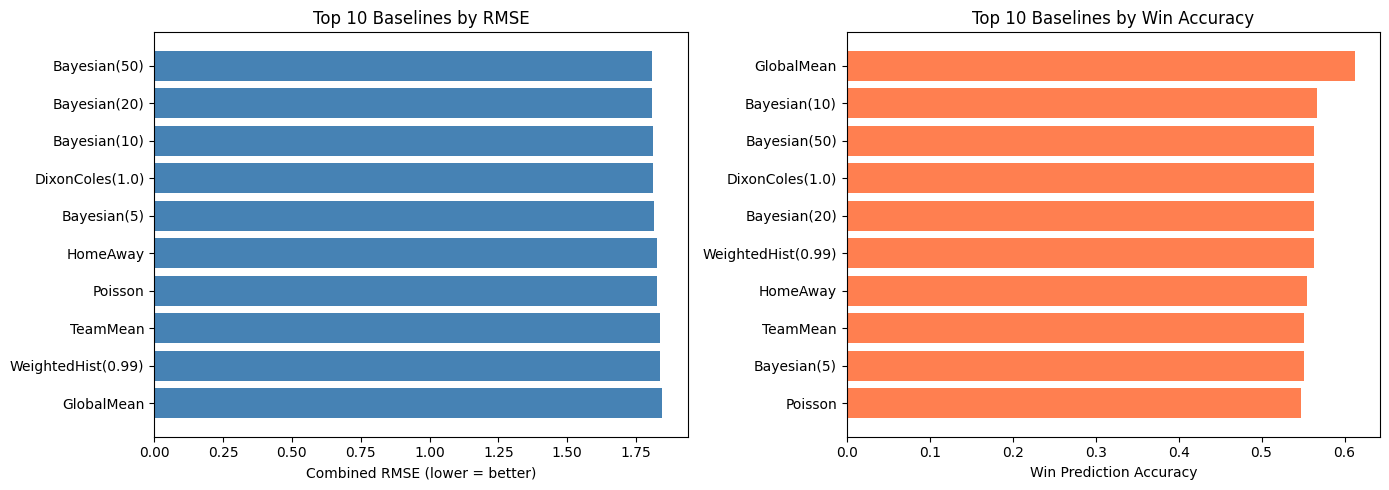

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

top = results_df.head(10)
axes[0].barh(top['model'], top['combined_rmse'], color='steelblue')
axes[0].set_xlabel('Combined RMSE (lower = better)')
axes[0].set_title('Top 10 Baselines by RMSE')
axes[0].invert_yaxis()

top_acc = results_df.sort_values('win_accuracy', ascending=False).head(10)
axes[1].barh(top_acc['model'], top_acc['win_accuracy'], color='coral')
axes[1].set_xlabel('Win Prediction Accuracy')
axes[1].set_title('Top 10 Baselines by Win Accuracy')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

## 5. Hyperparameter Tuning

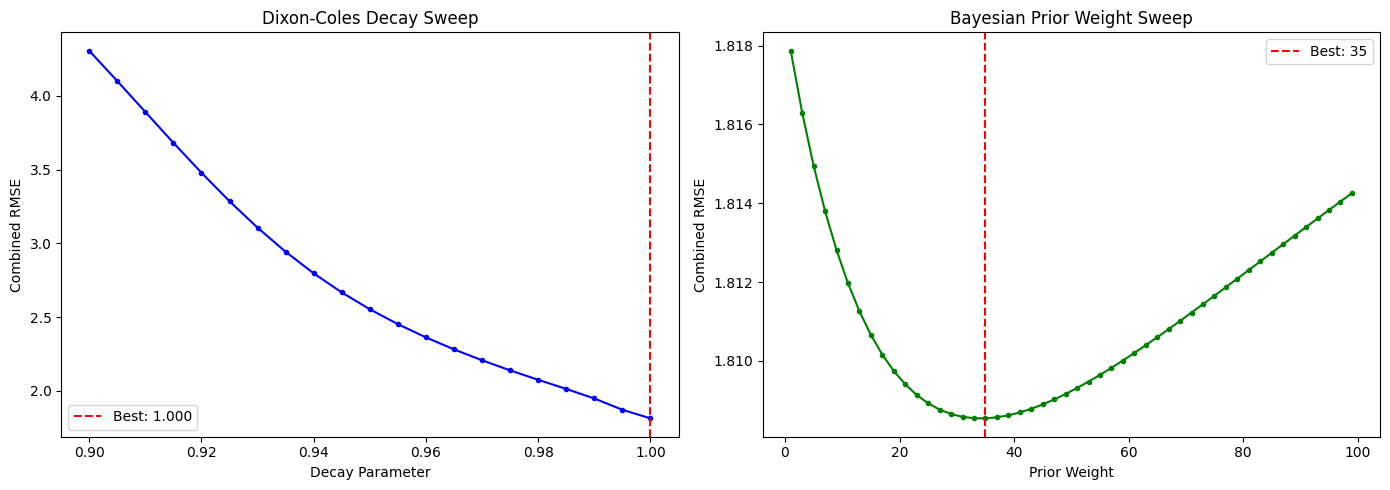

Best Dixon-Coles decay: 1.000 (RMSE 1.8126)
Best Bayesian prior_weight: 35 (RMSE 1.8085)


In [6]:
# Sweep Dixon-Coles decay (must be <= 1.0 to avoid overflow)
dc_decays = np.arange(0.90, 1.001, 0.005)
dc_rmses = []
for d in dc_decays:
    m = DixonColesBaseline({'decay': round(d, 4)})
    m.fit(train_df)
    dc_rmses.append(m.evaluate(test_df)['combined_rmse'])

# Sweep Bayesian prior_weight
bw_weights = np.arange(1, 101, 2)
bw_rmses = []
for w in bw_weights:
    m = BayesianTeamBaseline({'prior_weight': w})
    m.fit(train_df)
    bw_rmses.append(m.evaluate(test_df)['combined_rmse'])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(dc_decays, dc_rmses, 'b.-')
best_dc = dc_decays[np.argmin(dc_rmses)]
axes[0].axvline(best_dc, color='r', linestyle='--', label=f'Best: {best_dc:.3f}')
axes[0].set_xlabel('Decay Parameter')
axes[0].set_ylabel('Combined RMSE')
axes[0].set_title('Dixon-Coles Decay Sweep')
axes[0].legend()

axes[1].plot(bw_weights, bw_rmses, 'g.-')
best_bw = bw_weights[np.argmin(bw_rmses)]
axes[1].axvline(best_bw, color='r', linestyle='--', label=f'Best: {best_bw}')
axes[1].set_xlabel('Prior Weight')
axes[1].set_ylabel('Combined RMSE')
axes[1].set_title('Bayesian Prior Weight Sweep')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f'Best Dixon-Coles decay: {best_dc:.3f} (RMSE {min(dc_rmses):.4f})')
print(f'Best Bayesian prior_weight: {best_bw} (RMSE {min(bw_rmses):.4f})')

## 6. Build Ensemble

In [7]:
ensemble = EnsembleBaseline({'models': [
    HomeAwayBaseline(),
    PoissonBaseline(),
    DixonColesBaseline({'decay': best_dc}),
    BayesianTeamBaseline({'prior_weight': int(best_bw)}),
]})
ensemble.fit(train_df)
ens_metrics = ensemble.evaluate(test_df)

print(f'Ensemble RMSE:         {ens_metrics["combined_rmse"]:.4f}')
print(f'Ensemble Win Accuracy: {ens_metrics["win_accuracy"]:.1%}')

Ensemble RMSE:         1.8071
Ensemble Win Accuracy: 55.9%


## 7. Round 1 Predictions

In [8]:
matchups = pd.read_excel('data/WHSDSC_Rnd1_matchups.xlsx')
print(f'{len(matchups)} matchups loaded')
matchups.head()

16 matchups loaded


,game,game_id,home_team,away_team
0,1,game_1,brazil,kazakhstan
1,2,game_2,netherlands,mongolia
2,3,game_3,peru,rwanda
3,4,game_4,thailand,oman
4,5,game_5,pakistan,germany


In [9]:
# Re-fit on ALL data for final predictions
final_ensemble = EnsembleBaseline({'models': [
    HomeAwayBaseline(),
    PoissonBaseline(),
    DixonColesBaseline({'decay': best_dc}),
    BayesianTeamBaseline({'prior_weight': int(best_bw)}),
]})
final_ensemble.fit(games)

home_col = [c for c in matchups.columns if 'home' in c.lower()][0]
away_col = [c for c in matchups.columns if 'away' in c.lower()][0]

predictions = []
for _, row in matchups.iterrows():
    game = {'home_team': row[home_col], 'away_team': row[away_col]}
    h_goals, a_goals = final_ensemble.predict_goals(game)
    winner, conf = final_ensemble.predict_winner(game)
    predictions.append({
        'home_team': game['home_team'], 'away_team': game['away_team'],
        'pred_home': round(h_goals, 2), 'pred_away': round(a_goals, 2),
        'winner': winner, 'confidence': f'{conf:.1%}'
    })

pred_df = pd.DataFrame(predictions)
print(pred_df.to_string(index=False))

  home_team    away_team  pred_home  pred_away      winner confidence
     brazil   kazakhstan       3.71       1.88      brazil      77.9%
netherlands     mongolia       3.31       1.65 netherlands      76.9%
       peru       rwanda       3.63       1.88        peru      76.9%
   thailand         oman       4.38       2.83    thailand      71.5%
   pakistan      germany       3.79       2.47    pakistan      69.8%
      india          usa       3.56       2.30       india      69.6%
     panama  switzerland       3.34       2.13      panama      69.3%
    iceland       canada       3.52       2.29     iceland      69.3%
      china       france       3.47       2.29       china      68.6%
philippines      morocco       3.08       2.25 philippines      63.7%
   ethiopia saudi_arabia       3.09       2.35    ethiopia      62.3%
  singapore  new_zealand       3.28       2.82   singapore      57.3%
  guatemala  south_korea       3.78       3.07   guatemala      60.5%
         uk       me

## 8. Save Results

In [10]:
import json, pickle

os.makedirs('output/predictions/baseline', exist_ok=True)
os.makedirs('output/models/baseline', exist_ok=True)

# 1. Comparison CSV (all 17 configs)
results_df.to_csv('output/predictions/baseline/baseline_comparison.csv', index=False)

# 2. Predictions CSV (16 Round 1 games)
pred_df.to_csv('output/predictions/baseline/round1_baseline_predictions.csv', index=False)

# 3. Saved model
final_ensemble.save_model('output/models/baseline/best_baseline.pkl')

# 4. Pipeline summary JSON (single source of truth)
summary = {
    'best_single_model': results_df.iloc[0]['model'],
    'best_single_rmse': float(results_df.iloc[0]['combined_rmse']),
    'best_model': 'Ensemble',
    'best_rmse': float(ens_metrics['combined_rmse']),
    'tuned_params': {
        'dixon_coles_decay': float(best_dc),
        'bayesian_prior_weight': int(best_bw),
    },
    'ensemble_metrics': {k: float(v) for k, v in ens_metrics.items()},
    'predictions': pred_df.to_dict(orient='records'),
}
with open('output/predictions/baseline/baseline_pipeline_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print('Saved:')
print('  output/predictions/baseline/baseline_comparison.csv')
print('  output/predictions/baseline/round1_baseline_predictions.csv')
print('  output/predictions/baseline/baseline_pipeline_summary.json')
print('  output/models/baseline/best_baseline.pkl')

PermissionError: [Errno 13] Permission denied: 'output/predictions/baseline/baseline_comparison.csv'